<p align="center"><img src="./images/booking.jpg" height="300" width="600"></p>

# Проект: Построение модели, предсказывающей рейтинг отеля.

## Загрузка библитек и данных

In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import ast
from collections import Counter

# Для вычисления расстояния между двумя точками на земной поверхности
from geopy.distance import geodesic

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Для кодирования признаков
from category_encoders import BinaryEncoder

# библиотека для расчетов
from scipy import stats 

# импортируем библиотеки для оценки тональности отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Загрузим лексикон VADER, так как он лучше всего подходит для отзывов и комментариев.
nltk.downloader.download('vader_lexicon')
# Импортируем списки из стоп-слов
from nltk.corpus import stopwords
# Импортируем функцию для разбивки текста на слова
from nltk.tokenize import word_tokenize
# Загрузка ресурсов для корректной работы токенизации и фильтрации стоп-слов
nltk.download('punkt')
nltk.download('stopwords')

# Из библиотеки transformers импортируем необходимые модули для определения тональности
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

# для нормализации, стандартизации
from sklearn import preprocessing

# библиотеки для оценки значимости
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# Загружаем функцию для разделения датасета:
from sklearn.model_selection import train_test_split

# инструмент для создания и обучения модели 
from sklearn.ensemble import RandomForestRegressor  
# инструменты для оценки точности модели 
from sklearn import metrics 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные
df_train = pd.read_csv('data/hotels_train.csv')
df_test = pd.read_csv('data/hotels_test.csv')
sample_submission = pd.read_csv('data/submission.csv')

## Знакомство с данными

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Посмотрим на рапределение нашего целевого признака.

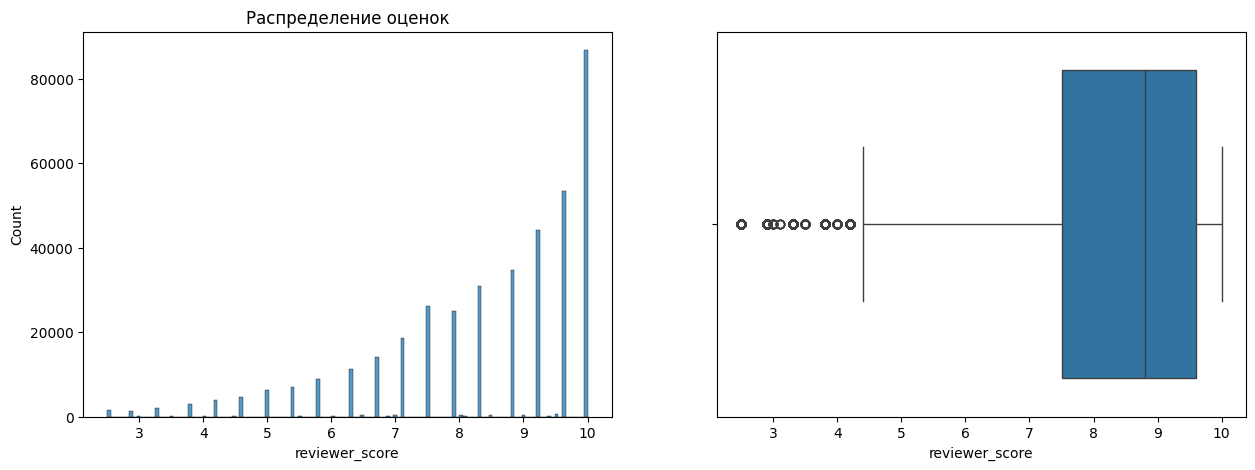

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df_train, x = 'reviewer_score', ax=axes[0])

sns.boxplot(df_train, x = 'reviewer_score', ax=axes[1])
axes[0].set_title('Распределение оценок');

Из графиков видим, что хороших оценок больше чем плохих.

In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


Для корректной обработки признаков объединяем трейн и тест в один датасет

In [10]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
# объединяем
data = pd.concat([df_train, df_test], ignore_index=True) 

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [12]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1


Объединенный датасет содержит 18 полей со следующей информацией:

* **hotel_address** — адрес отеля;
* **review_date** — дата, когда рецензент разместил соответствующий отзыв;
* **average_score** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* **hotel_name** — название отеля;
* **reviewer_nationality** — страна рецензента;
* **negative_review** — отрицательный отзыв, который рецензент дал отелю;
* **review_total_negative_word_counts** — общее количество слов в отрицательном отзыв;
* **positive_review** — положительный отзыв, который рецензент дал отелю;
* **review_total_positive_word_counts** — общее количество слов в положительном отзыве.
* **reviewer_score** — оценка, которую рецензент поставил отелю на основе своего опыта;
* **total_number_of_reviews_reviewer_has_given** — количество отзывов, которые рецензенты дали в прошлом;
* **total_number_of_reviews** — общее количество действительных отзывов об отеле;
* **tags** — теги, которые рецензент дал отелю;
* **days_since_review** — количество дней между датой проверки и датой очистки;
* **additional_number_of_scoring** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* **lat** — географическая широта отеля;
* **lng** — географическая долгота отеля.
* **sample** — флаг, помечающий где тест, а где трейн(1-трейн, 0-тест)

In [13]:
# Описательная статистика для нечисловых признаков
data.describe(include=['object'])

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


In [14]:
# Описательная статистика для числовых признаков 
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,sample
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,49.442439,2.823803,0.749999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,3.466325,4.579425,0.433014
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,48.214662,-0.143372,0.250000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.010607,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.000000


## Очистка данных


Проверим на наличие дубликатов

In [15]:
print(f'Количество полных дубликатов: {data[data.duplicated()].shape[0]}')

Количество полных дубликатов: 336


Удалим дубликаты

(закометировал код, пока не будем удалять дубликаты, так как это нарушает размерность тестовой части, из-за этого количество предсказанных оценок не совпадает с количеством строк в сабмишне)

In [265]:
# data = data.drop_duplicates()
# data.shape

Посмотрим в каких столбцах есть пропуски

In [16]:
cols_null = data.isnull().sum()
cols_with_null = cols_null[cols_null>0].sort_values(ascending=False)
display(cols_with_null)

lat    3268
lng    3268
dtype: int64

Найдем у каких отелей нет координат

In [17]:
missing_coords = data[data['lat'].isnull() | data['lng'].isnull()]
missing_coords_grouped = missing_coords.groupby('hotel_name').size().reset_index(name='count')
missing_coords_grouped

,hotel_name,count
0,Austria Trend Hotel Schloss Wilhelminenberg Wien,194
1,City Hotel Deutschmeister,93
2,Cordial Theaterhotel Wien,57
3,Derag Livinghotel Kaiser Franz Joseph Vienna,147
4,Fleming s Selection Hotel Wien City,658
5,Holiday Inn Paris Montmartre,55
6,Hotel Advance,28
7,Hotel Atlanta,389
8,Hotel City Central,563
9,Hotel Daniel Vienna,245


У 17 отелей отсутствуют координаты

Заполним пропуски координатами, взятыми с сайта Google Maps Platform

In [18]:
# Запарсить сайт не получилось, так как отелей с пропусками немного, вручную создал словарь
coords = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': ['48.219569, 16.285592'],
          'City Hotel Deutschmeister': ['48.220852, 16.366612'],
          'Cordial Theaterhotel Wien': ['48.209549, 16.351463'],
          'Derag Livinghotel Kaiser Franz Joseph Vienna': ['48.20807, 16.371309'],
          'Fleming s Selection Hotel Wien City': ['48.20807, 16.371309'],
          'Holiday Inn Paris Montmartre': ['48.888909, 2.333153'],
          'Hotel Advance': ['41.383239, 2.16295'],
          'Hotel Atlanta': ['48.22041, 16.355819'],
          'Hotel City Central': ['48.213587, 16.379908'],
          'Hotel Daniel Vienna': ['48.188815, 16.383779'],
          'Hotel Park Villa': ['48.233586, 16.345681'],
          'Hotel Pension Baron am Schottentor': ['48.224596, 16.354379'],
          'Maison Albar Hotel Paris Op ra Diamond':['48.875317, 2.323392'],
          'Mercure Paris Gare Montparnasse': ['48.839996, 2.323562'],
          'NH Collection Barcelona Podium': ['41.391548, 2.177894'],
          'Renaissance Barcelona Hotel': ['41.392685, 2.167398'],
          'Roomz Vienna': ['48.222761, 16.393487']}


# прошелся циклом по словарю
for hotel, coord in coords.items():
    # разделяем строку координат
    lat, lng = coord[0].split(', ')
    # Присваивает значения столбцам lat и lng, где `hotel_name` совпадает с текущим ключом словаря coords
    data.loc[data['hotel_name'] == hotel, 'lat'] = float(lat)
    data.loc[data['hotel_name'] == hotel, 'lng'] = float(lng)

In [19]:
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
dtype: int64

Пропусков больше нет.

Проверим, есть ли отели с одинаковым названием и разными адресами:

In [37]:
# Группируем данные по названию отеля и адресу и считаем количество уникальных адресов
hotel_address_count = data.groupby('hotel_name')['hotel_address'].nunique()
hotel_address_count.sort_values(ascending=False)

# Фильтруем отели с более чем одним уникальным адресом
multiple_addresses = hotel_address_count[hotel_address_count > 1].index

# Получаем уникальные адреса этих отелей
unique_addresses = data[data['hotel_name'].isin(multiple_addresses)][['hotel_name', 'hotel_address']].drop_duplicates()
unique_addresses

,hotel_name,hotel_address
479,Hotel Regina,Bergara 2 4 Eixample 08002 Barcelona Spain
1428,Hotel Regina,Rooseveltplatz 15 09 Alsergrund 1090 Vienna Au...
1566,Hotel Regina,Via Cesare Correnti 13 Milan City Center 20123...


Отель с названием "Hotel Regina" есть в трех городах, в Барселоне, Вене и Милане. 

## Разведывательный анализ и генерация фичей.

### Выделим страну город из признака hotel_address

Визуально изучим какие данные хранятся в колонке hotel_address:

In [38]:
def extracting_city(hotel_address):
    """Функция для извлечения города из адреса

    Args:
        hotel_address (pd.Series): Колонка с адресом отеля

    Returns:
        str : Город, в котором находится отель
    """
    lst_adress = hotel_address.split(' ')
    if lst_adress[-1] == 'Kingdom':
        return lst_adress[-5]
    else:
        return lst_adress[-2]
    
    
    
def extracting_country(hotel_adress):
    """Функция для извлечения страны из адреса

    Args:
        hotel_address (pd.Series): Колонка с адресом отеля

    Returns:
        str : Страна, в которой находится отель
    """
    lst_adress = hotel_adress.split(' ')
    if lst_adress[-1] == 'Kingdom':
        return 'United Kingdom'
    else:
        return lst_adress[-1]  
    
# Создадим новые прзнаки, применив наши функции 
data['city'] = data['hotel_address'].apply(extracting_city)
data['country'] = data['hotel_address'].apply(extracting_country)

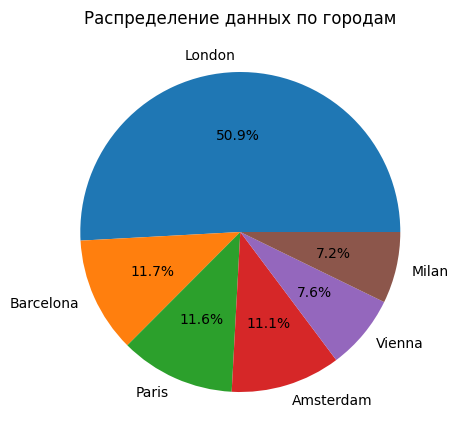

In [39]:
# визуализируем распределение данных по городам
city = data['city'].value_counts()
fig = plt.figure(figsize=(4, 6))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(city, labels = city.index, autopct = '%.1f%%')
plt.title('Распределение данных по городам');

Видим, что в данных находятся отели только из 6 городов, половина из них, это лондонские отели.


Удалим признак country, так как в наших данных каждую страну представляет только один город.

In [40]:
encoded_data = data.drop(['country'], axis=1)

### Преобразование колонки review_date

Извлекем из review_date год, месяц и день недели.
Год бронирования может отражать общие тенденции в индустрии, которые могут влиять на удовлетворенность гостей, месяц бронирования может быть связан с сезонностью в туристической индустрии,  день недели бронирования может отражать различия в поведении и предпочтениях гостей, например, между выходными и будними днями, гости, путешествующие в будние дни, могут иметь другие ожидания и потребности, чем те, кто приезжает на выходные.


In [41]:
encoded_data['review_date'] = pd.to_datetime(encoded_data['review_date'])

# извлекаем год из даты
encoded_data['year'] = encoded_data['review_date'].dt.year
# извлекаем месяц из даты
encoded_data['month'] = encoded_data['review_date'].dt.month
# извлекаем день недели из даты
encoded_data['day_of_week'] = encoded_data['review_date'].dt.dayofweek

In [42]:
def get_season(month):
    """Функция для создания признака "Сезон"

    Args:
        month (ште): Номер месяца

    Returns:
        str: Название сезона
    """
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
    
encoded_data['season'] = encoded_data['month'].apply(get_season)    

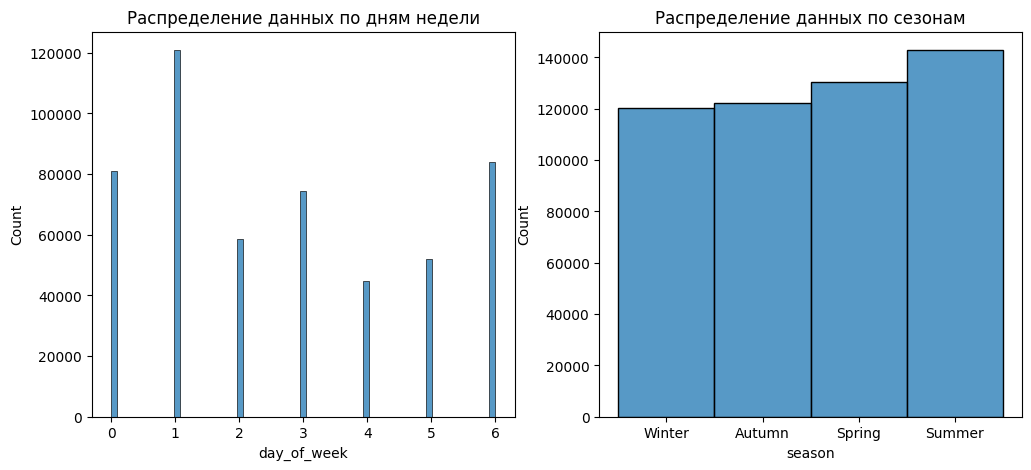

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
hist = sns.histplot(encoded_data['day_of_week'], ax=axes[0])
hist1 = sns.histplot(encoded_data['season'], ax=axes[1])
hist.set_title('Распределение данных по дням недели')
hist1.set_title('Распределение данных по сезонам');

Видим, что данные по сезонам рапределились равномерно, по дням недели выделяется вторник, в этот день больше всего данных.

Закодируем признак year

In [44]:
# Применим к признаку year метод One-Hot Encoding
encoded_data = pd.get_dummies(encoded_data, columns=['year'])

Закодируем признак month.

Используем One-Hot Encoding, так как эта методика лучше всего совместима с деревьями решений и не вводит дополнительных признаков, которые могут быть избыточными.

In [45]:
# Применим к признаку month метод One-Hot Encoding
encoded_data = pd.get_dummies(encoded_data, columns=['month'])

Закодируем признак day_of_week

In [46]:
# Применим к признаку day_of_week метод One-Hot Encoding
encoded_data = pd.get_dummies(encoded_data, columns=['day_of_week'])

Закодируем признак season

In [47]:
# Применим к признаку season метод One-Hot Encoding
encoded_data = pd.get_dummies(encoded_data, columns=['season'])

### Работа с признаком reviewer_nationality

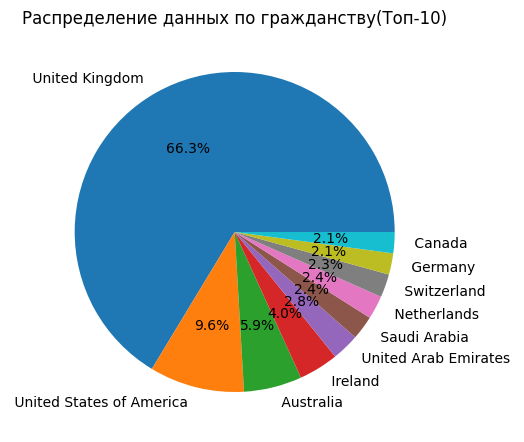

In [48]:
# визуализируем распределение данных по гражданству
reviewer = encoded_data['reviewer_nationality'].value_counts().head(10)
fig = plt.figure(figsize=(6, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(reviewer, labels = reviewer.index, autopct = '%.1f%%')
plt.title('Распределение данных по гражданству(Топ-10)');

Видим, что большинство ревьюеров представляют Великобританию.

Создадим новый признак, который показывает количество национальностей, оставивших отзыв на отель.

In [49]:
# Вычислим количество уникальных национальностей для каждого отеля
num_nationalities = encoded_data.groupby('hotel_name')['reviewer_nationality'].nunique()
display(num_nationalities)

# Добавим новый признак в DataFrame
encoded_data['num_unique_nationalities'] = encoded_data['hotel_name'].map(num_nationalities)

hotel_name
11 Cadogan Gardens                    36
1K Hotel                              39
25hours Hotel beim MuseumsQuartier    77
41                                    23
45 Park Lane Dorchester Collection     8
                                      ..
citizenM London Bankside              72
citizenM London Shoreditch            62
citizenM Tower of London              83
every hotel Piccadilly                60
pentahotel Vienna                     43
Name: reviewer_nationality, Length: 1492, dtype: int64

Сократим количество уникальных значений в признаке reviewer_nationality

Оставим только топ-10, остальные пометим, как other.

In [50]:
# Создаем список с топ-10 национальностей по количеству отзывов
popular_nationalities = list(encoded_data['reviewer_nationality'].value_counts()[:10].index)
# С помощью lambda-функции преобразовываем признак
encoded_data['reviewer_nationality'] = encoded_data['reviewer_nationality'].apply(lambda x: x if x in popular_nationalities else 'other')

Закодируем признак reviewer_nationality

Будем использовать One-Hot Encoding так как он является более подходящим методом, когда не предполагается никакого порядка между категориями.

In [51]:
# Убираем лишние пробелы
encoded_data['reviewer_nationality'] = encoded_data['reviewer_nationality'].str.strip()  
# Закодируем методом One-Hot Encoding
encoded_data = pd.get_dummies(encoded_data, columns=['reviewer_nationality'], prefix='nationality')

### Работа с признаками negative_review и positive_review

In [52]:
# Создадим признак "процент положительных слов в отзывах"
encoded_data['percent_positive_words'] = encoded_data['review_total_positive_word_counts'] / encoded_data['total_number_of_reviews_reviewer_has_given']
# Создадим признак "процент отрицательных слов в отзывах"
encoded_data['percent_negative_words'] = encoded_data['review_total_negative_word_counts'] / encoded_data['total_number_of_reviews_reviewer_has_given']

In [287]:
# BERT ИСПОЛЬЗОВАТЬ НЕ БУДЕМ, СЛИШКОМ СЛОЖНАЯ МОДЕЛЬ, НЕРЕАЛЬНО ДОЛГО БУДЕТ ОБРАБАТЫВАТЬ ВЕСЬ ДАТАФРЕЙМ

# Загружаем предобученный токенизатор 
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
# и модель для анализа тональности
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Создаем пайплайн указываем задачу, как анализ тональности, так же передаем ему нашу модель и токенизатор. 
sentiment_analysis = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)


# Создаем функцию
def get_tonality_score(text):
    """ Функция для получения коеффициента тональности

    Args:
        text (str): Отзыв на отель 

    Returns:
        float: Коеффициент тональности, который зависит от количества звезд от пайплайна
    """
    result = sentiment_analysis(text)[0]
    score = result['score']
    if result['label'] == '1 star':
        return score * -2
    elif result['label'] == '2 stars':
        return score * -1
    elif result['label'] == '3 stars':
        return 0
    elif result['label'] == '4 stars':
        return score * 1
    elif result['label'] == '5 stars':
        return score * 2
    
t = 'Very central location 2 minutes walk from Gloucester Rd tube station and 10 15 minutes walk from the museums Lots of restaurants and bars on the doorstep '
get_tonality_score(t)  

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


0.3805617690086365

Будем использовать более простую модель для анализа тональности, такую как VADER

In [56]:
#  Создаем анализатор
sia = SentimentIntensityAnalyzer()
# Создаем функции для анализа тональности текста отзывов
def get_compound_review(review):
   """
   Функция возвращает общую оценку тональности
   """
   result = sia.polarity_scores(review)
   return result['compound']

def get_pos_review(review):
   """
   Функция возвращает позитивную оценку
   """
   result = sia.polarity_scores(review)
   return result['pos']

def get_neu_review(review):
   """
   Функция возвращает нейтральную оценку
   """ 
   result = sia.polarity_scores(review)
   return result['neu']

def get_neg_review(review):
   """
   Функция возвращает негативную оценку
   """
   result = sia.polarity_scores(review)
   return result['neg']

Комметрарий No Positive в положительных отзывах является негативной реакцией, а No Negative в негативных комментариях положительной реакцией, но VADER отбрасывает слово No и оценивает только слово Positive и Negative. Поэтому в столбце positive_review комментарий No Positive, мы заменим на Negative, а в столбце negative_review комментарий No Negative, на Positive

In [57]:
encoded_data['positive_review'] = encoded_data['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))
encoded_data['negative_review'] = encoded_data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))

Определим самые често встречающиеся слова в positive_review

In [58]:
# Объединим отзывы в одну строку
all_review = ' '.join(encoded_data['positive_review'])

# Создание списка стоп-слов
stop_words = list(set(stopwords.words('english')))

# Токенизация текста(разделение строки на слова)
tokens = word_tokenize(all_review.lower())

# удалим стоп слова
tokens = list(filter(lambda x: x not in stop_words, tokens))

# Подсчет частоты слов
word_counter = Counter(tokens)

# Вывод 20 самых популярных слов
most_common_words = word_counter.most_common(20)
print(most_common_words)

[('staff', 194574), ('location', 192856), ('room', 140746), ('hotel', 125326), ('good', 112321), ('great', 105641), ('friendly', 85353), ('breakfast', 84581), ('helpful', 76183), ('nice', 69449), ('clean', 66929), ('excellent', 62272), ('comfortable', 59952), ('bed', 49926), ('rooms', 40370), ('negative', 36182), ('lovely', 35096), ('stay', 32031), ('close', 30971), ('station', 29312)]


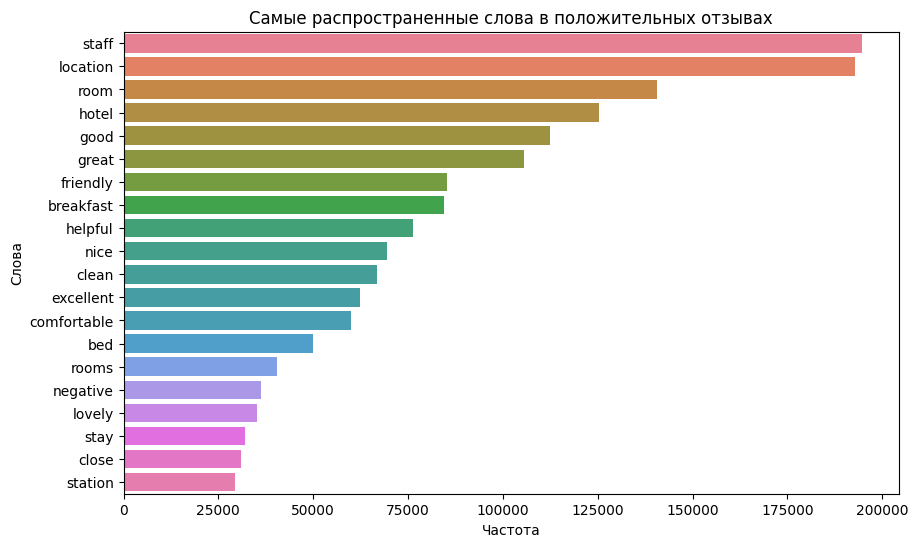

In [59]:
# Преобразование в DataFrame для визуализации
df = pd.DataFrame(word_counter.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='word', data=df.head(20),hue='word')
plt.title('Самые распространенные слова в положительных отзывах')
plt.xlabel('Частота')
plt.ylabel('Слова')
plt.show()

Определим самые често встречающиеся слова в negative_review

In [60]:
# Объединим отзывы в одну строку
all_neg_review = ' '.join(encoded_data['negative_review'])

# Токенизация текста(разделение строки на слова)
neg_tokens = word_tokenize(all_neg_review.lower())

# удалим стоп слова
neg_tokens = list(filter(lambda x: x not in stop_words, neg_tokens))

# Подсчет частоты слов
neg_word_counter = Counter(neg_tokens)

# Вывод 20 самых популярных слов
most_common_neg_words = neg_word_counter.most_common(20)
print(most_common_neg_words)

[('room', 176026), ('positive', 128127), ('hotel', 74709), ('breakfast', 58478), ('small', 49880), ('staff', 39512), ('nothing', 38768), ('rooms', 34802), ('would', 32291), ('could', 32079), ('bed', 29828), ('one', 28095), ('bit', 27546), ('bathroom', 26585), ('night', 24063), ('little', 22536), ('like', 22445), ('shower', 21290), ('good', 20821), ('us', 20225)]


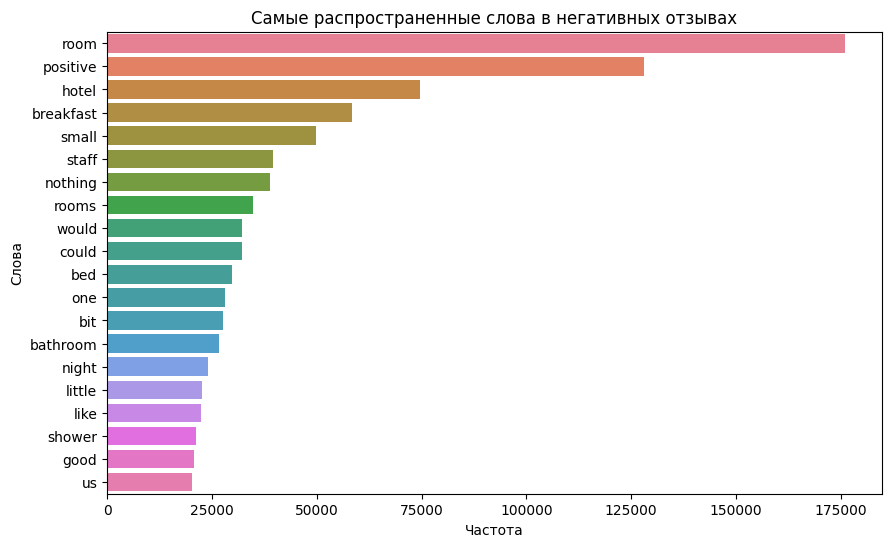

In [61]:
# Преобразование в DataFrame для визуализации
neg_df = pd.DataFrame(neg_word_counter.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='word', data=neg_df.head(20),hue='word')
plt.title('Самые распространенные слова в негативных отзывах')
plt.xlabel('Частота')
plt.ylabel('Слова')
plt.show()

Видим, что слова Small и nothing одни из самых распространенных, поэтому могут влиять на оценку, но VADER оценивает их, как нейтральные, хотя в контексте негативных отзывов слово Small имеет отрицательную окраску, а слово nothing, наоборот, положительную. Нужно подсказать VADER, как он должен воспринимать эти слова.

Для этого создадим словарь, в котором ключ - это слово, а значение - это сила и направление эмоциональной окраски слова.

Обновим лексикон:


In [62]:
neg = {'small': -1, 'nothing': 2}
# Обновление лексикона
sia.lexicon.update(neg)
sia.polarity_scores('nothing')

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4588}

Создадим новые признаки

In [63]:
# Общая оценка
encoded_data['compound_tonality_neg_review'] = encoded_data['negative_review'].apply(get_compound_review) 
encoded_data['compound_tonality_pos_review'] = encoded_data['positive_review'].apply(get_compound_review)

# Позитивная оценка 
encoded_data['pos_tonality_neg_review'] = encoded_data['negative_review'].apply(get_pos_review)
encoded_data['pos_tonality_pos_review'] = encoded_data['positive_review'].apply(get_pos_review)

# Нейтральная оценка
encoded_data['neu_tonality_neg_review'] = encoded_data['negative_review'].apply(get_neu_review)
encoded_data['neu_tonality_pos_review'] = encoded_data['positive_review'].apply(get_neu_review)

# Негативная оценка
encoded_data['neg_tonality_neg_review'] = encoded_data['negative_review'].apply(get_neg_review)
encoded_data['neg_tonality_pos_review'] = encoded_data['positive_review'].apply(get_neg_review)

In [65]:
# Посмотрим на описательную статистику новых фичей(оющая оценка тональности)
encoded_data[['compound_tonality_pos_review', 'compound_tonality_neg_review']].describe()

,compound_tonality_pos_review,compound_tonality_neg_review
count,515738.000000,515738.000000
mean,0.531959,0.118656
std,0.449727,0.454122
min,-0.983200,-0.998100
25%,0.361200,-0.250000
50%,0.708900,0.025800
75%,0.883400,0.557400
max,0.999300,0.996400


### Работа с признаком tags

In [66]:
# Для преобразования строкового представления списка в список используем функцию ast.literal_eval из модуля ast
encoded_data['tags'] = encoded_data['tags'].apply(ast.literal_eval)

Выделим тип номера из тэгов:

In [67]:
# Создадим функцию для извлечения типа номера
# Используем конструкцию try - except, чтобы избежать ошибки, если длинна списка окажется меньше, чем ожидается
def get_room_type(tags):
    try:
        if tags[0] in [' Leisure trip ', ' Business trip ']:
            return tags[2]
        else:
            return tags[1]
    except IndexError:
        return ' unknown '
    
# Создадим новый признак 
encoded_data['room_type'] = encoded_data['tags'].apply(get_room_type)

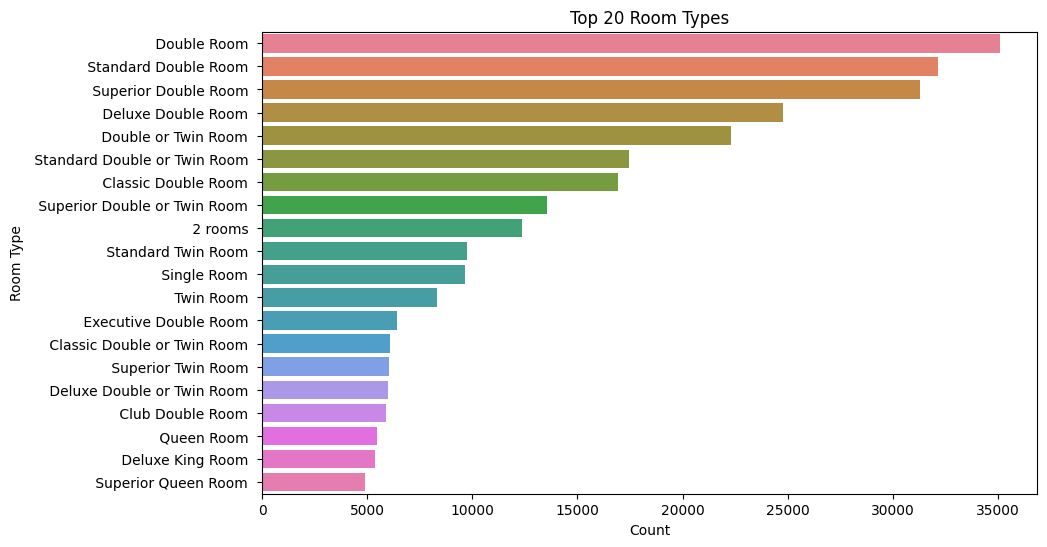

In [68]:
# найдем топ 20 по популярности видов номеров
top_20_room_types = encoded_data['room_type'].value_counts().nlargest(20)

# Построим график
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_room_types.values, y=top_20_room_types.index, hue=top_20_room_types.index)

# Заголовки
plt.title('Top 20 Room Types')
plt.xlabel('Count')
plt.ylabel('Room Type')
plt.show()

In [69]:
# Посмортрим сколько уникальных значений в новом признаке
encoded_data['room_type'].nunique()

2394

Видим, что значений много, попробуем закодировать признак методом BinaryEncoder, так как он хорошо подходит для категориальных признаков с большим количеством уникальных значений.

In [70]:
# Создаем обьект BinaryEncoder, указываем столбец для кодирования
encoder = BinaryEncoder(cols=['room_type'])
# Применяем метод fit_transform к столбцу, чтобы закодировать его
encoded_room = encoder.fit_transform(encoded_data['room_type'])
# Удаляем изначальный признак
encoded_data = encoded_data.drop('room_type', axis=1)
# Объединяем основной датафрейм и закодированный признак
encoded_data = pd.concat([encoded_data, encoded_room], axis=1)

encoded_data.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,room_type_2,room_type_3,room_type_4,room_type_5,room_type_6,room_type_7,room_type_8,room_type_9,room_type_10,room_type_11
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,Leaving,3,1994,Staff were amazing,4,...,0,0,0,0,0,0,0,0,0,1


Выделим из признака тип путешествия:

In [71]:
encoded_data['type_of_travel'] = encoded_data['tags'].apply(lambda x: x[0] if x[0] in [' Leisure trip ', ' Business trip '] else ' not specified ')

Посмотрим на рапределение признака "Тип путешествия"

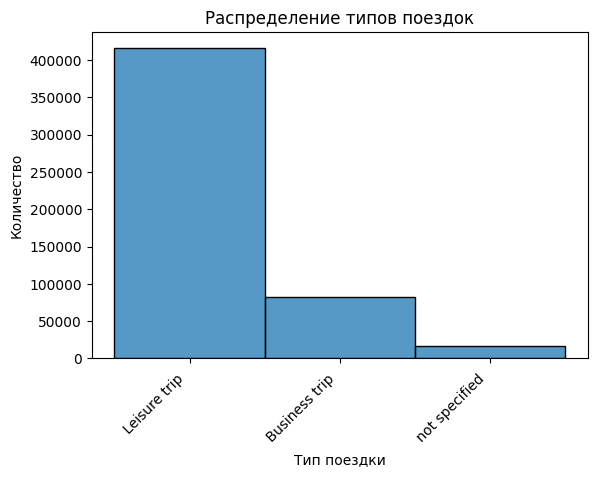

In [72]:
# Построим гистограмму
sns.histplot(encoded_data, x='type_of_travel')

# Настройка надписей на оси x
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

plt.title('Распределение типов поездок')
plt.xlabel('Тип поездки')
plt.ylabel('Количество')
plt.show()

In [73]:
encoded_data['type_of_travel'].value_counts(normalize=True) * 100

 Leisure trip      80.791410
 Business trip     16.044581
 not specified      3.164010
Name: type_of_travel, dtype: float64

Видим, что большинство поездок были туристическими, таких поездок более 80%, 3% гостей не указали тип путешествия.

Закодируем признак type_of_travel методом One-Hot Encoding

In [74]:
encoded_data = pd.get_dummies(encoded_data, columns=['type_of_travel'])

Создадим признак traveler_group.

In [75]:
encoded_data['traveler_group'] = encoded_data['tags'].apply(lambda x: x[1] if x[0] in [' Leisure trip ', ' Business trip '] else x[0])

Посмотрим, как распределились данные в признаке:

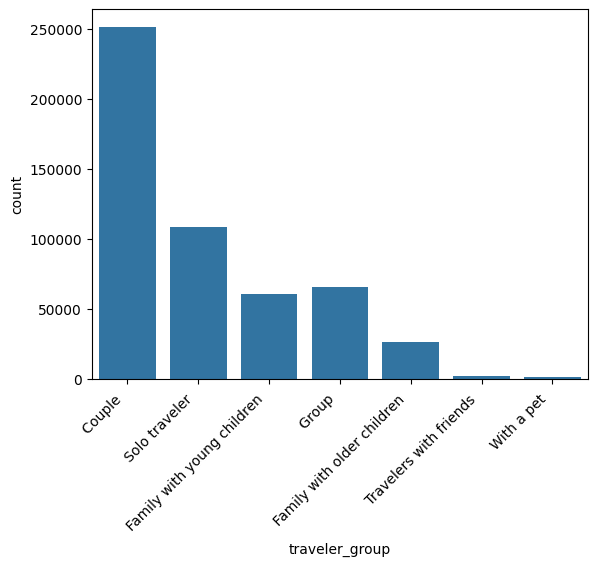

In [76]:
# Построим столбчатую диаграмму частот
sns.countplot(data=encoded_data, x='traveler_group')

# Повернем метки по оси x на 45 градусов
plt.xticks(rotation=45, ha='right')

plt.show()

In [77]:
encoded_data['traveler_group'].value_counts(normalize=True)*100

 Couple                         48.775541
 Solo traveler                  21.006015
 Group                          12.651967
 Family with young children     11.787187
 Family with older children      5.091345
 Travelers with friends          0.415521
 With a pet                      0.272425
Name: traveler_group, dtype: float64

Почти половина гостей путешествовали парами.

Закодируем признак traveler_group

In [78]:
encoded_data = pd.get_dummies(encoded_data, columns=['traveler_group'])

Создадим новую фичу "Количество ночей, проведенных в отеле"

In [79]:
def extracting_num_of_nights(lst):
    """Функция, которая извлекает из списка тэгов количество ночей

    Args:
        lst (list): Список тэгов

    Returns:
        int: Кол-во ночей, проведенных в отеле.
    """
    num_nights = 0
    for tag in lst:
        if 'Stayed' in tag:
            words = tag.split()
            for i, word in enumerate(words):
                if word =='Stayed':
                    try:
                        num_nights = int(words[i+1])
                        return num_nights
                    except (IndexError, ValueError):
                        pass
    return num_nights                

In [80]:
# Создаем признак, применив нашу функцию
encoded_data['num_of_nights'] = encoded_data['tags'].apply(extracting_num_of_nights)

Посмотрим на рапределение признака

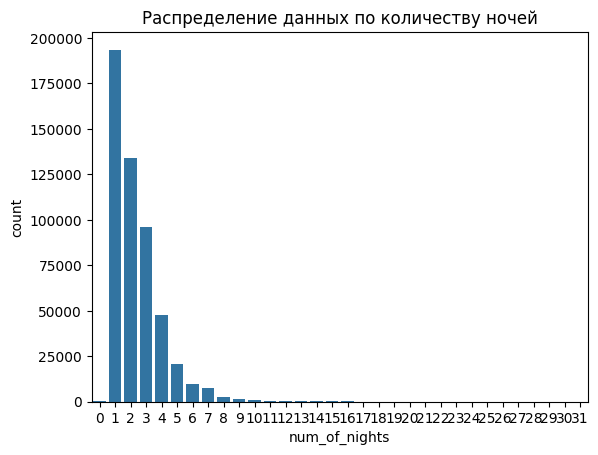

In [81]:
sns.countplot(encoded_data, x='num_of_nights')
plt.title('Распределение данных по количеству ночей');

In [82]:
encoded_data['num_of_nights'].value_counts(normalize=True)*100

1     37.547165
2     25.969969
3     18.579395
4      9.271568
5      4.041781
6      1.895536
7      1.434643
8      0.485130
9      0.250709
10     0.172374
11     0.081049
12     0.061271
14     0.047893
13     0.047699
0      0.037228
15     0.022686
16     0.011052
17     0.008144
18     0.006399
19     0.005623
21     0.004460
20     0.003684
30     0.002133
27     0.002133
22     0.001939
23     0.001939
28     0.001357
26     0.001357
25     0.001357
24     0.001163
29     0.000969
31     0.000194
Name: num_of_nights, dtype: float64

37% путешественников останавливались в отеле на 1 ночь, затем чем больше ночей, тем меньше гостей. 

Сократим количество категорий в признаке num_of_nights, разделим данные в признаке на группы.

In [83]:
# создаем функцию
def bin_num_of_nights(num_of_nights):
    """Функция группирует количество ночей

    Args:
        num_of_nights (int): Количество ночей, проведенных в отеле

    Returns:
        str: Название группы
    """
    if num_of_nights == 0:
        return 'не указано'
    if num_of_nights == 1:
        return '1 ночь'
    elif num_of_nights <= 3:
        return '2-3 ночи'
    elif num_of_nights <= 7:
        return '4-7 ночей'
    else:
        return 'Более 7 ночей'


In [84]:
# Создаем новый признак, применив функцию bin_num_of_nights ко всему столбцу num_of_nights
encoded_data['num_of_nights_group'] = encoded_data['num_of_nights'].apply(bin_num_of_nights)


Теперь посмотрим, как рапределились данные, разделенные по группам.

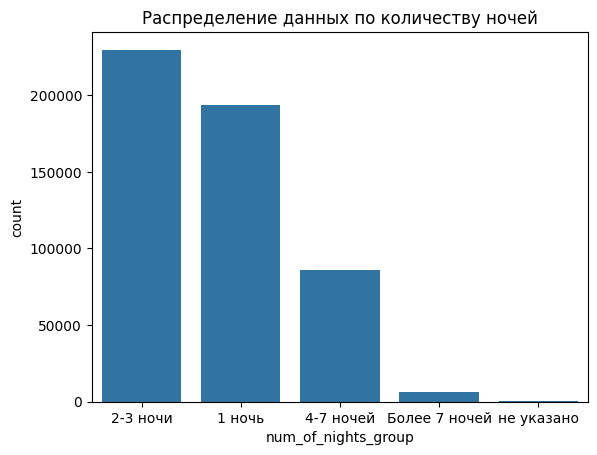

In [85]:
sns.countplot(encoded_data, x='num_of_nights_group')
plt.title('Распределение данных по количеству ночей');

In [86]:
encoded_data['num_of_nights_group'].value_counts()

2-3 ночи         229758
1 ночь           193645
4-7 ночей         85837
Более 7 ночей      6306
не указано          192
Name: num_of_nights_group, dtype: int64

Закодируем признак, чтобы можно было подать его на обучение модели.


In [87]:
# Используем метод One-Hot Encoding
encoded_data = pd.get_dummies(encoded_data, columns=['num_of_nights_group'])

Создадим признак, показывающий откуда был отправлен отзыв (с мобильного устройства или нет).

**1** - с мобильного устройства

**0** - не с мобильного устройства

In [88]:
# С помощью lambda-функции создаем фичу
encoded_data['submitted_from_a_mobile_device'] = encoded_data['tags'].apply(lambda x: 1 if ' Submitted from a mobile device ' in x else 0)

Посмотрим как распределились данные в признаке:

In [89]:
encoded_data['submitted_from_a_mobile_device'].value_counts(normalize=True)*100

1    59.650443
0    40.349557
Name: submitted_from_a_mobile_device, dtype: float64

Почти 60% отзывов отпралено с мобильного устройства.

Закодируем признак

In [90]:
# С помощью метода One-Hot Encoding
encoded_data = pd.get_dummies(encoded_data, columns=['submitted_from_a_mobile_device'])

### Работа с признаками lat и lng.

С помощью этих признаков создадим новый - расстояние от центра города.

С Яндекс карт возьмем координаты номинальных центров городов. 

Создадим словарь, где ключ - это город, а значение - его координаты.

In [91]:
# Создаем словарь с координатами центров городов
center_coords = {'London': (51.507351, -0.127696),
                 'Paris': (48.856663, 2.351556),
                 'Amsterdam': (52.373057, 4.892557),
                 'Milan': (45.464183, 9.189595),
                 'Vienna': (48.220692, 16.371805),
                'Barcelona': (41.386378, 2.186760)}

In [92]:
# Создаем новый признак 'distance_from_center', с помощью функции geodesic()
encoded_data['distance_from_center'] = encoded_data.apply(lambda x: geodesic((x['lat'], x['lng']), center_coords[x['city']]).km, axis=1)

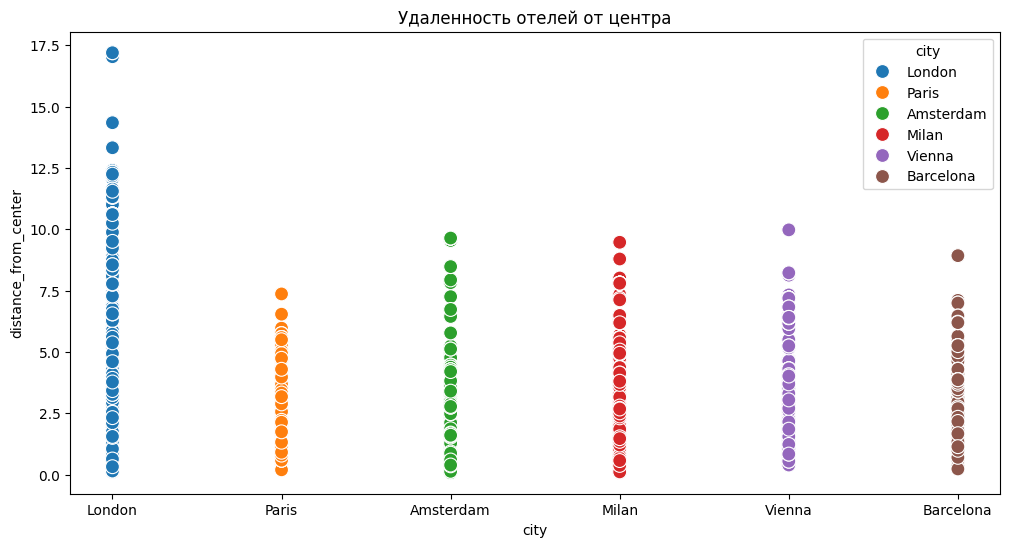

In [93]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='city', y='distance_from_center', data=encoded_data, hue='city', s=100)
plt.title('Удаленность отелей от центра')
plt.show()

Видим, что у лондонских отелей самая широкая география, а парижские отели расположены компактнее всего.

### Отбор признаков

Сделаем копию нашего датафрейма

In [94]:
df = encoded_data.copy()

In [95]:
# Посмотрим какие признаки с типом object у нас остались
list(df.select_dtypes(include=[object]))

['hotel_address',
 'hotel_name',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review',
 'city']

Закодируем признак city, остальные удалим 

In [96]:
df = pd.get_dummies(df, columns=['city'])

In [97]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)

In [98]:
# Так же удалим колонку с датой
df.drop(['review_date'], axis=1, inplace=True)

In [99]:
# Посмотрим, сколько всего признаков у нас есть
f'Всего колонок в таблице: {len(list(df.columns))} шт.'

'Всего колонок в таблице: 95 шт.'

Разделим признаки на непрерывные и категориальные.

In [103]:
# непрерывные признаки
num_col = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 
           'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
           'lat', 'lng', 'num_unique_nationalities', 'percent_positive_words', 'percent_negative_words', 'distance_from_center',
           'compound_tonality_neg_review', 'compound_tonality_pos_review', 'pos_tonality_neg_review', 'pos_tonality_pos_review',
           'neu_tonality_neg_review', 'neu_tonality_pos_review', 'neg_tonality_neg_review', 'neg_tonality_pos_review']


# категориальные признаки
cat_col = ['city_Vienna', 'city_Paris', 'city_Milan', 'city_London' ,'city_Barcelona', 'city_Amsterdam', 'year_2015', 'year_2016', 
           'year_2017', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
           'month_11', 'month_12', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 
           'day_of_week_6', 'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter', 'nationality_Australia',
           'nationality_Canada', 'nationality_Germany', 'nationality_Ireland', 'nationality_Netherlands', 'nationality_Saudi Arabia',
           'nationality_Switzerland', 'nationality_United Arab Emirates', 'nationality_United Kingdom', 
           'nationality_United States of America', 'nationality_other', 'type_of_travel_ Business trip ', 'type_of_travel_ Leisure trip ',
           'type_of_travel_ not specified ', 'traveler_group_ Couple ', 'traveler_group_ Family with older children ',
           'traveler_group_ Family with young children ','traveler_group_ Group ', 'traveler_group_ Solo traveler ',
           'traveler_group_ Travelers with friends ', 'traveler_group_ With a pet ', 'num_of_nights', 'num_of_nights_group_1 ночь', 
           'num_of_nights_group_2-3 ночи', 'num_of_nights_group_4-7 ночей', 'num_of_nights_group_Более 7 ночей', 
           'num_of_nights_group_не указано', 'submitted_from_a_mobile_device_0', 'submitted_from_a_mobile_device_1', 'room_type_0',
           'room_type_1', 'room_type_2', 'room_type_3', 'room_type_4', 'room_type_5', 'room_type_6', 'room_type_7', 'room_type_8',
           'room_type_9', 'room_type_10', 'room_type_11']

### Проверка на мультиколлинеарность

Для непрерывных признаков:

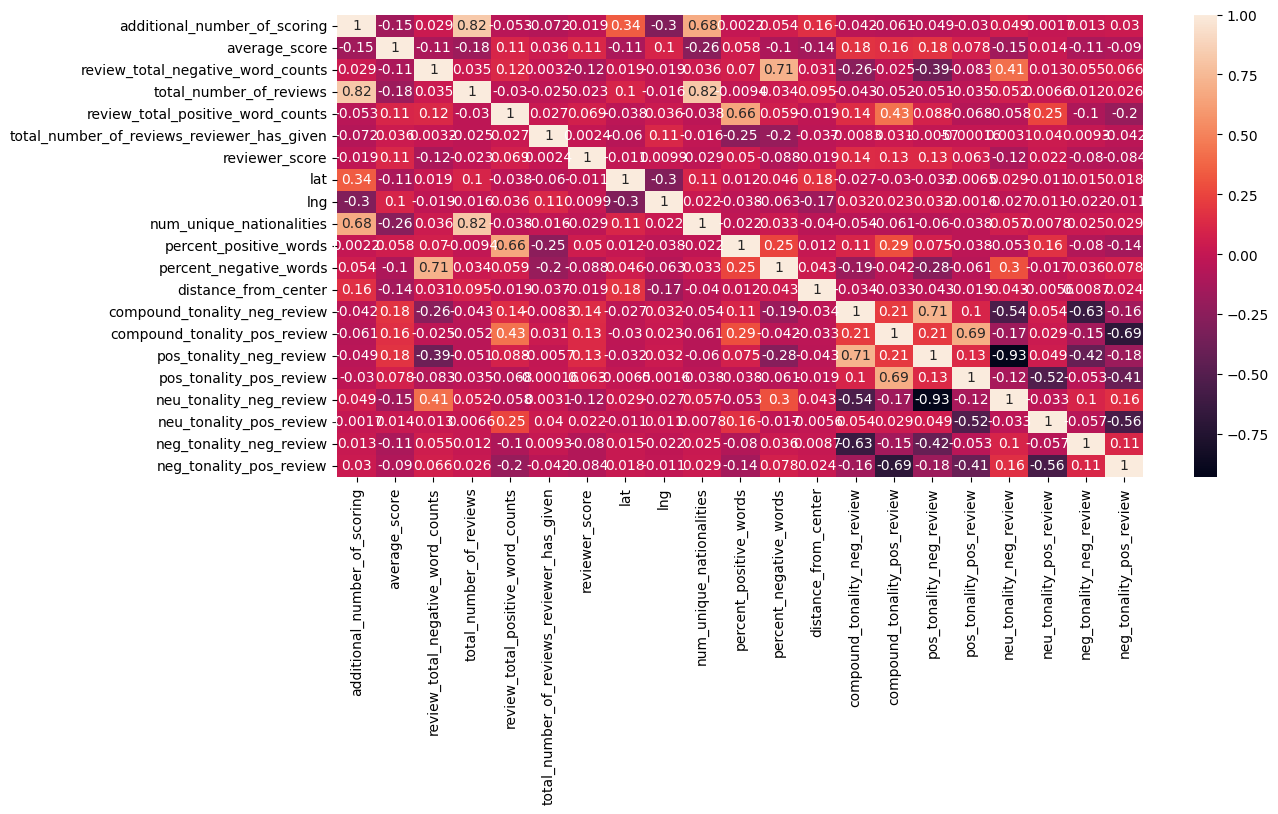

In [105]:
# Построим тепловую карту корреляционной матрицы для непрерывных признаков
plt.figure(figsize=(13, 6))
sns.heatmap(df[num_col].corr(method='pearson'), annot=True);

In [106]:
def get_redundant_pairs(df):
    '''Функция предназначена для получения набора пар столбцов DataFrame,
       которые соответствуют диагонали и нижней треугольной части матрицы корреляции.
    '''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

get_redundant_pairs(df[num_col])

{('additional_number_of_scoring', 'additional_number_of_scoring'),
 ('average_score', 'additional_number_of_scoring'),
 ('average_score', 'average_score'),
 ('compound_tonality_neg_review', 'additional_number_of_scoring'),
 ('compound_tonality_neg_review', 'average_score'),
 ('compound_tonality_neg_review', 'compound_tonality_neg_review'),
 ('compound_tonality_neg_review', 'distance_from_center'),
 ('compound_tonality_neg_review', 'lat'),
 ('compound_tonality_neg_review', 'lng'),
 ('compound_tonality_neg_review', 'num_unique_nationalities'),
 ('compound_tonality_neg_review', 'percent_negative_words'),
 ('compound_tonality_neg_review', 'percent_positive_words'),
 ('compound_tonality_neg_review', 'review_total_negative_word_counts'),
 ('compound_tonality_neg_review', 'review_total_positive_word_counts'),
 ('compound_tonality_neg_review', 'reviewer_score'),
 ('compound_tonality_neg_review', 'total_number_of_reviews'),
 ('compound_tonality_neg_review',
  'total_number_of_reviews_reviewer_h

In [107]:
def get_top_abs_correlations(df, n=5):
    """Функция get_top_abs_correlations(df, n=5) предназначена для получения топ-n пар столбцов из DataFrame,
       которые имеют наивысшие значения абсолютной корреляции 
    """
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(df[num_col], 10)

pos_tonality_neg_review            neu_tonality_neg_review     0.928285
additional_number_of_scoring       total_number_of_reviews     0.824884
total_number_of_reviews            num_unique_nationalities    0.815917
compound_tonality_neg_review       pos_tonality_neg_review     0.714895
review_total_negative_word_counts  percent_negative_words      0.711694
compound_tonality_pos_review       neg_tonality_pos_review     0.693122
                                   pos_tonality_pos_review     0.686803
additional_number_of_scoring       num_unique_nationalities    0.678272
review_total_positive_word_counts  percent_positive_words      0.658386
compound_tonality_neg_review       neg_tonality_neg_review     0.634153
dtype: float64

In [108]:
# Удалим признаки с высокой корреляцией
df = df.drop(['total_number_of_reviews', 'neu_tonality_neg_review'], axis=1)

Для категориальных признаков

In [109]:

df[cat_col].corr(method='spearman')

,city_Vienna,city_Paris,city_Milan,city_London,city_Barcelona,city_Amsterdam,year_2015,year_2016,year_2017,month_1,...,room_type_2,room_type_3,room_type_4,room_type_5,room_type_6,room_type_7,room_type_8,room_type_9,room_type_10,room_type_11
city_Vienna,1.000000,-0.103621,-0.079686,-0.290730,-0.103837,-0.100947,0.018211,-0.001363,-0.013836,0.004649,...,0.023994,0.006341,0.028353,0.036850,0.002717,-0.012716,-0.025816,0.011536,0.013832,-0.008176
city_Paris,-0.103621,1.000000,-0.101107,-0.368882,-0.131750,-0.128083,0.025117,-0.018318,-0.001221,-0.012896,...,0.087873,0.038950,0.037820,0.016158,-0.023215,0.034017,0.003530,0.068469,0.066391,-0.020705
city_Milan,-0.079686,-0.101107,1.000000,-0.283676,-0.101318,-0.098498,-0.002702,-0.000958,0.003313,-0.014606,...,-0.017305,0.003582,-0.028961,-0.013731,-0.013832,-0.014297,0.010857,0.042187,-0.078590,0.006252
city_London,-0.290730,-0.368882,-0.283676,1.000000,-0.369652,-0.359364,-0.012369,0.013613,-0.004389,0.024256,...,-0.083447,-0.059448,-0.051379,-0.008356,0.047301,0.036261,-0.028361,-0.215580,0.050076,0.005044
city_Barcelona,-0.103837,-0.131750,-0.101318,-0.369652,1.000000,-0.128351,0.002851,-0.002907,0.000761,-0.021675,...,0.047271,0.042137,0.048009,-0.009560,-0.048631,-0.052049,0.096164,0.158944,-0.059616,0.005000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
room_type_7,-0.012716,0.034017,-0.014297,0.036261,-0.052049,-0.016762,0.005244,-0.004591,0.000578,0.003502,...,0.074065,0.080322,0.074662,0.076246,0.181983,1.000000,-0.134027,0.039945,0.030295,0.136215
room_type_8,-0.025816,0.003530,0.010857,-0.028361,0.096164,-0.043964,-0.012280,-0.007057,0.017996,0.002856,...,0.005266,-0.001010,0.045459,-0.055741,-0.196936,-0.134027,1.000000,-0.018442,-0.103103,0.101145
room_type_9,0.011536,0.068469,0.042187,-0.215580,0.158944,0.066397,-0.001928,-0.002375,0.004202,-0.009327,...,0.007918,0.038841,0.075638,0.071396,0.051566,0.039945,-0.018442,1.000000,0.041413,0.032974
room_type_10,0.013832,0.066391,-0.078590,0.050076,-0.059616,-0.033421,0.006049,0.000611,-0.005751,0.001929,...,0.026394,0.067936,0.136605,0.053085,-0.093994,0.030295,-0.103103,0.041413,1.000000,-0.156725


Из-за большого количества признаков тепловая карта становится нечитабельной, поэтому посмотрим на топ пар с самой высокой корреляцией с помощью функции:

In [110]:
get_top_abs_correlations(df[cat_col])

submitted_from_a_mobile_device_0  submitted_from_a_mobile_device_1    1.000000
type_of_travel_ Business trip     type_of_travel_ Leisure trip        0.896550
num_of_nights_group_1 ночь        num_of_nights_group_2-3 ночи        0.694992
year_2016                         year_2017                           0.677932
num_of_nights                     num_of_nights_group_4-7 ночей       0.642245
dtype: float64

In [112]:
# Удалим признаки с высокой корреляцией
df = df.drop(['submitted_from_a_mobile_device_0', 'type_of_travel_ Business trip '], axis=1)

Посмотрим на топ пар с высокой корреляцией во всем датасете:

In [113]:
get_top_abs_correlations(df, 10)

reviewer_score                     sample                          0.931753
lat                                city_Barcelona                  0.844610
lng                                city_Vienna                     0.824927
compound_tonality_neg_review       pos_tonality_neg_review         0.714895
review_total_negative_word_counts  percent_negative_words          0.711694
num_of_nights_group_1 ночь         num_of_nights_group_2-3 ночи    0.694992
compound_tonality_pos_review       neg_tonality_pos_review         0.693122
                                   pos_tonality_pos_review         0.686803
additional_number_of_scoring       num_unique_nationalities        0.678272
year_2016                          year_2017                       0.677932
dtype: float64

In [114]:
# Удалим столбцы lat и lng
df = df.drop(['lat', 'lng'], axis=1)

In [115]:
# Так же удалим признак num_of_nights, так как мы сгруппировали количество ночей
df = df.drop(['num_of_nights'], axis=1)

In [116]:
get_top_abs_correlations(df, 10)

reviewer_score                     sample                          0.931753
compound_tonality_neg_review       pos_tonality_neg_review         0.714895
review_total_negative_word_counts  percent_negative_words          0.711694
num_of_nights_group_1 ночь         num_of_nights_group_2-3 ночи    0.694992
compound_tonality_pos_review       neg_tonality_pos_review         0.693122
                                   pos_tonality_pos_review         0.686803
additional_number_of_scoring       num_unique_nationalities        0.678272
year_2016                          year_2017                       0.677932
review_total_positive_word_counts  percent_positive_words          0.658386
compound_tonality_neg_review       neg_tonality_neg_review         0.634153
dtype: float64

### Оценка значимости модели

In [117]:
# разбиваем датафрейм на части (X - данные с информацией об отелях, y - целевая переменная)
X = df.drop(['reviewer_score'], axis = 1)
y = df['reviewer_score'].astype('int')

Оценка значимости непрерывных признаков

In [118]:
# Список из удаленных ранее столбцов, так же здесь наша целевая переменная
del_feat = ['reviewer_score', 'total_number_of_reviews', 'lat', 'lng', 'neu_tonality_neg_review']
# Удаляем с помощью функции filter и lambda из списка из непрерывных признаков список с удаленными признаками
num_col = list(filter(lambda x: x not in del_feat, num_col))

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит ANOVA. Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

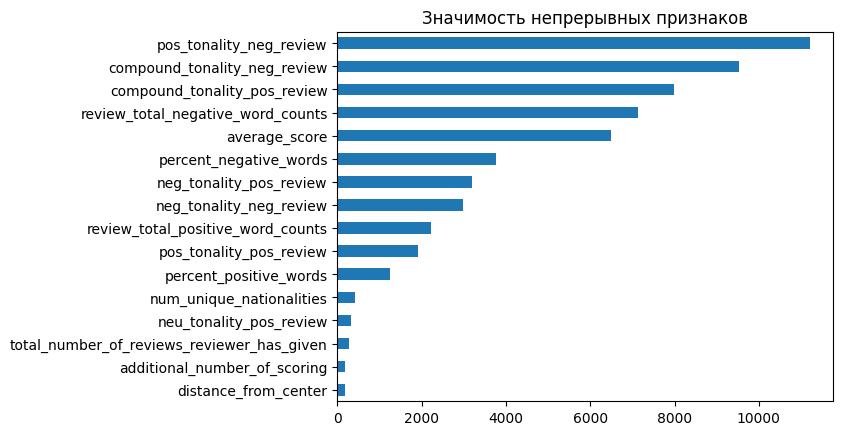

In [119]:
# Используем  функцию f_classif
imp_num = pd.Series(f_classif(X[num_col], y)[0], index = num_col)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Значимость непрерывных признаков');

Оценка значиммости категориальных признаков

In [120]:
# список из ранее удаленных столбцов
del_cat = ['type_of_travel_ Business trip ', 'submitted_from_a_mobile_device_0', 'num_of_nights']
# Отфильтровываем с помощью функции filter и lambda из списка из категориальных признаков список с удаленными признаками
cat_col = list(filter(lambda x: x not in del_cat, cat_col))

Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

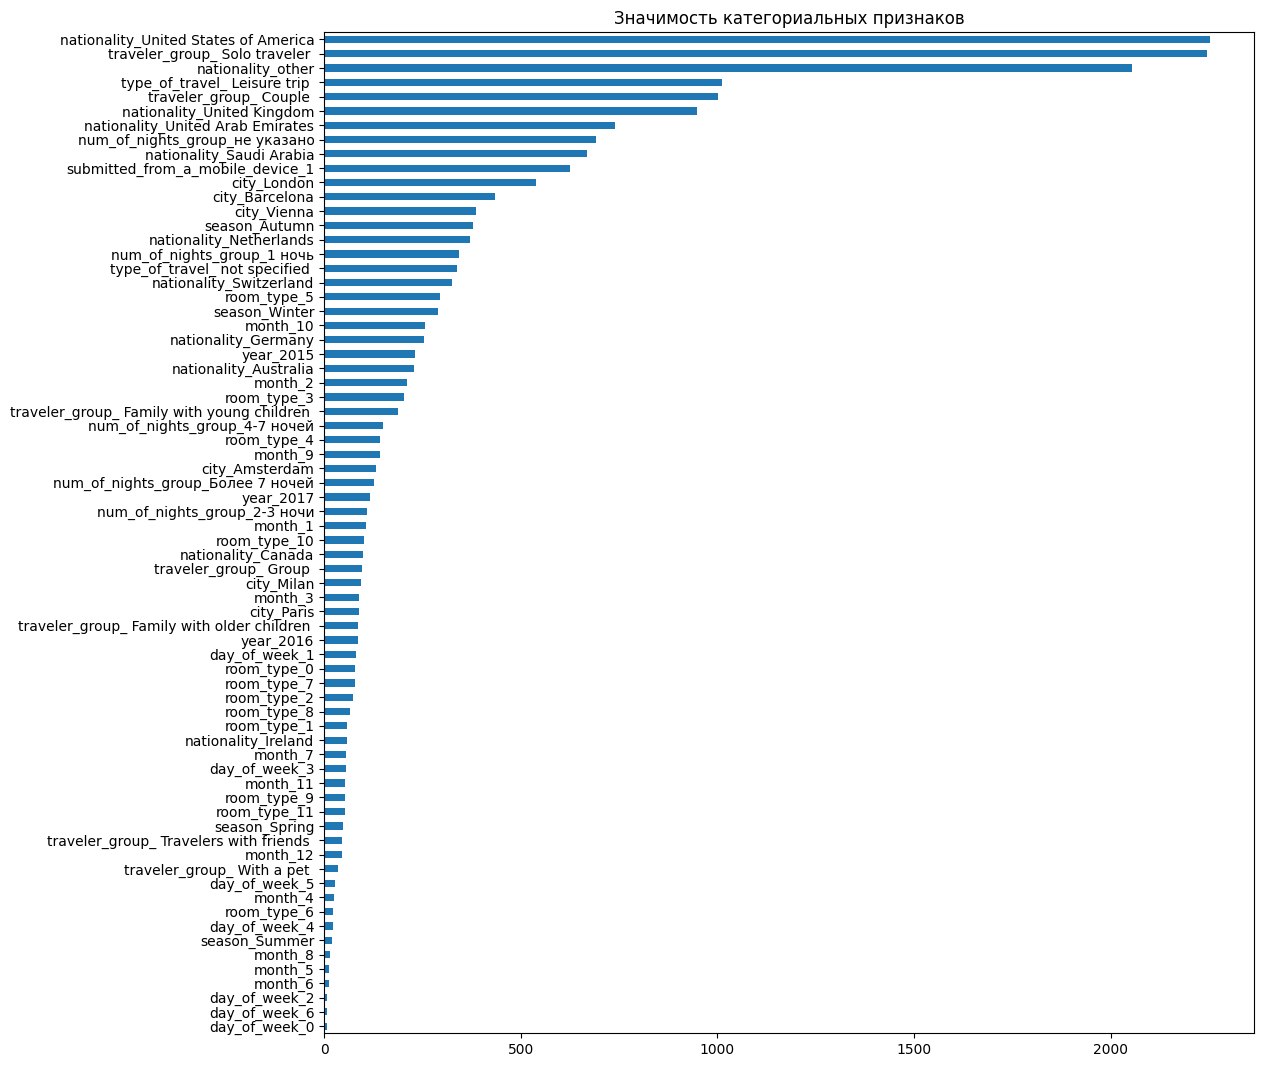

In [121]:
plt.figure(figsize=(12, 13))
imp_cat = pd.Series(chi2(X[cat_col], y)[0], index=cat_col)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Значимость категориальных признаков');

Удалим наименее значимые признаки

In [122]:
# Создаем список столбцов, которые будем удалять, в него войдут все признаки у которых p-value меньше медианного значения
cols_to_drop = list(imp_cat[imp_cat.values < imp_cat.median()].index)

In [123]:
df = df.drop(cols_to_drop, axis=1)

In [124]:
df.shape

(515738, 53)

## Обучение модели

In [125]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)


# Удалим дубликаты только из тренировочной выборки, это хоть чуть-чуть, но улучшает метрику.
# Еще лучше ее улучшало удаление дубликатов со всего датасета, но тогда количество строк в
# тестовой выборке и сабмите не совпадает.
print(f'Количество полных дубликатов: {train_data[train_data.duplicated()].shape[0]}')

train_data = train_data.drop_duplicates()



# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

Количество полных дубликатов: 323


In [126]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [127]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 52), (386480, 52), (386480, 51), (309184, 51), (77296, 51))

In [128]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=1, random_state=RANDOM_SEED)  

# Обучаем модель 
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 12.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.4s finished


In [129]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку 
# предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12247710601215521


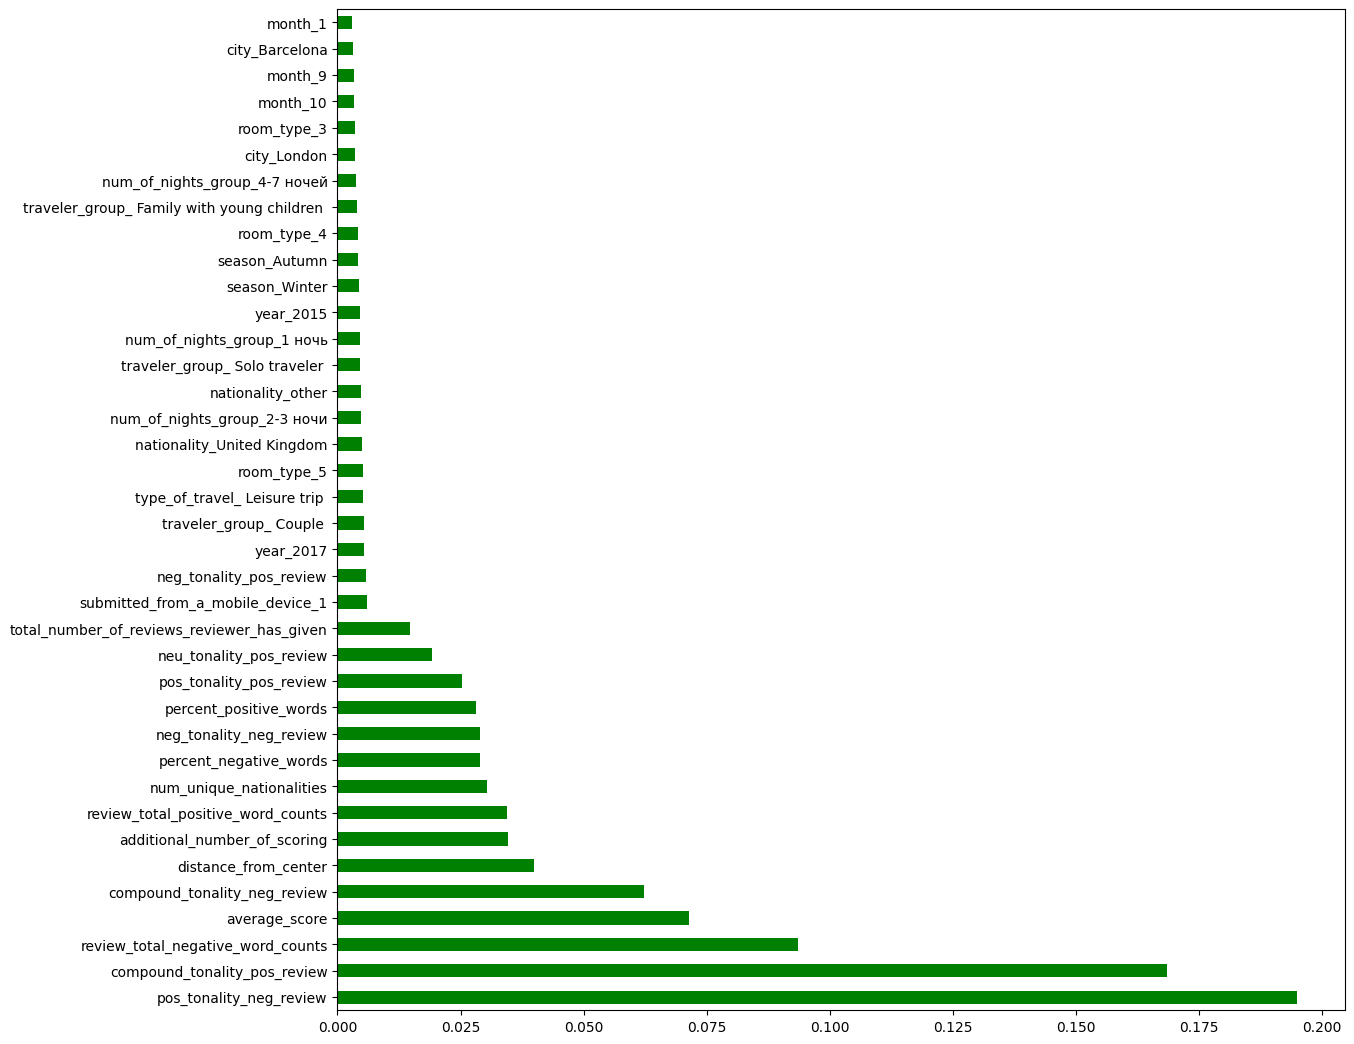

In [130]:
# в RandomForestRegressor есть возможность вывести самые важные признаки
plt.figure(figsize=(13, 13))
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(38).plot(kind='barh', color='green');

## Предсказание целевого признака (оценки, которую рецензент поставил отелю на основе своего опыта)

In [131]:
# Посмотрим на 5 случайных строк тестового датасета
test_data.sample(5)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,year_2015,year_2017,month_1,month_2,...,num_of_nights_group_2-3 ночи,num_of_nights_group_4-7 ночей,num_of_nights_group_Более 7 ночей,num_of_nights_group_не указано,submitted_from_a_mobile_device_1,distance_from_center,city_Amsterdam,city_Barcelona,city_London,city_Vienna
399458,687,8.2,6,13,10,0.0,0,1,0,0,...,1,0,0,0,0,3.460071,0,0,1,0
469170,439,8.0,18,24,14,0.0,0,0,0,0,...,0,0,0,0,0,1.323705,0,1,0,0
450110,975,8.7,18,18,15,0.0,0,1,0,0,...,0,0,0,0,1,2.481724,1,0,0,0
392280,214,7.8,17,29,3,0.0,0,0,0,0,...,0,1,0,0,0,1.188281,0,0,0,1
446684,289,8.8,0,5,9,0.0,1,0,0,0,...,1,0,0,0,0,3.742607,0,0,1,0


In [132]:
# Удалим целевой признак из тестовой выборки
test_data = test_data.drop(['reviewer_score'], axis=1)

In [133]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [134]:
# Используем нашу модель для предсказания целевой переменной
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.4s finished


In [135]:
test_data.shape

(128935, 51)

In [136]:
# Применяем к столбцу reviewer_score в сабмишне значения, полученный моделью
sample_submission['reviewer_score'] = predict_submission
# Записываем полученный датафрейм в csv-файл
sample_submission.to_csv('predict_submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.527,488440
1,7.636,274649
2,7.984,374688
3,9.635,404352
4,9.386,451596
5,9.075,302161
6,7.883,317079
7,8.059,13963
8,8.962,159785
9,7.439,195089


## Вывод

Познали силу разведывательного анализа, без настройки модели, только за счет EDA удалось значительно повысить точность предсказания ретинга отеля.